### **PROGETTO FALL DETECTION - UNIVPM (PERNIOLA STEFANO)**

Passi definiti:
1. ricerca in letteratura scientifica delle pubblicazioni sulla "fall detection", con particolare riferimento alle tecniche basate sulla visione
  - fallnet:https://ejmcm.comarticle_5270_c142136d00a954b48008a9226edd5a07.pdf
  - posenet:https://www.mdpi.com/2076-3417/11/1/329
  - MHI:https://cocosci.princeton.edu/rachit/images/FallRecog.pdf
2. individuazione di datasets annotati di varia origine e "formati" già presenti in letteratura relativi alla "fall detection", con particolare riferimento a quelli basti su videoriprese
  - UR Fall Detection Dataset:http://fenix.univ.rzeszow.pl/mkepski/ds/uf.html
  - Fall Detection Dataset(4 classi):https://falldataset.com/
  - Label+BB:https://www.kaggle.com/datasets/uttejkumarkandagatla/fall-detection-dataset
  - 
3. primi esperimenti di training utilizzando da 6 a 10 diversi algoritmi di apprendimento basati su deep neural networks
  - colab
4. creazione un set di dati in ambienti di videosorveglianza realistici, utilizzando più telecamere con frame rate di 25 fps e risoluzione di  640×480 pixel; i video devono rappresentare le principali difficoltà delle sequenze video realistiche che possiamo trovare in un ambiente domestico per anziani, così come in una stanza di un ufficio più semplice. sotto illuminazione variabile e difficoltà tipiche come occlusioni o sfondo ingombro. Gli attori (da 1 a 4) svolgono varie attività quotidiane e cadute. Almeno 180 video annotati.
5. ripetizione degli esperimenti di training con il nuovo dataset proprietario
6. individuazione di un algoritmo per la ricerca del consenso fra differenti riconoscitori situati in punti diversi della stanza
7. sperimentazione conclusiva e rilascio del codice addestrato su Raspberry Pi4
8. (OPTIONAL) porting delle reti addestrate su board STM32


Attività svolte:

Dataset utilizzato: http://fenix.univ.rzeszow.pl/mkepski/ds/uf.html

1) Struttura dataset: 

images/immagine.jpg --> annotazioni.csv (immagine.jpg,[1-0]) 0: not fall, 1: fall
  - Quindi per ogni immagine del dataset abbiamo un record nel file csv in cui viene scritto se quell'immagine corrisponde ad una caduta o meno.

2) Ur Fall Detection Dataset:
  - Scaricate le 30 sequenze di fall (train_images) e le 40 di adl (adl-all-cam0-rgb) 
  - Per ogni sequenza di fall e adl sono state scritte le annotazioni in csv (rispettivamente in fall-csv e adl-csv)
  - Creato file unico train_labels.csv contenente tutte le annotazioni di fall-csv (30 sequenze di fall)
  - Usate 27 sequenze di fall per training (train_images), 2 per il test (le seq.29,30 -> test_images), 1 per validation (splittato con scikit in colab)
  - Da provare ad aggiungere le sequenza di cam1 (depth camera) alle immagini di training e test(con relative annotazioni) 

3) Colab
- Preparazione dataset conclusa
- Definita architettura della fallnet
- Effettuato training dei modelli (cam0 e cam1) su diverse epoche
- Effettuato test dei modelli (accuracy, loss)

4) Risultati
- Fallnet: 
     - 15 epoche: >95%
     - cam0 accuracy: 164/169 (97.04%)
     - cam1 accuracy: 163/169 (96.45%)
- Altri modelli (TODO):
    - ...
    - ...


TODO: 
- k fold cross validation (usando le 30 sequenze di fall)
- Provare altri modelli 
- Annotare e aggiungere i dati di cam1 (depth camera)
- Aggiungere dati di adl
- Aggiungere ulteriori metriche di valutazione dei 
modelli



## Import librerie

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from google.colab import drive
import keras

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing dataset (eseguire una volta)

In [ ]:
#!unzip drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl/cam1.zip

In [ ]:
#!mv cam1/* drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl/

In [ ]:
# Converto i file png in jpg
'''
from PIL import Image

data_path = "drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl"

from PIL import Image

folders = ["test_images/","train_images/"]

for folder in folders:
  folder_path = os.path.join(data_path, folder)
  for file in os.listdir(folder_path):
    im1 = Image.open(folder_path+file)
    im1.save(folder_path+file[:len(file) - 4]+'.jpg')
'''

'\nfrom PIL import Image\n\ndata_path = "drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl"\n\nfrom PIL import Image\n\nfolders = ["test_images/","train_images/"]\n\nfor folder in folders:\n  folder_path = os.path.join(data_path, folder)\n  for file in os.listdir(folder_path):\n    im1 = Image.open(folder_path+file)\n    im1.save(folder_path+file[:len(file) - 4]+\'.jpg\')\n'

In [ ]:
# Elimino i vecchi file png
'''
data_path = "drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl"

from PIL import Image

folders = ["test_images/","train_images/"]

for folder in folders:
  folder_path = os.path.join(data_path, folder)
  for file in os.listdir(folder_path):
    if ".png" in file:
      os.remove(folder_path+file)
'''

'\ndata_path = "drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl"\n\nfrom PIL import Image\n\nfolders = ["test_images/","train_images/"]\n\nfor folder in folders:\n  folder_path = os.path.join(data_path, folder)\n  for file in os.listdir(folder_path):\n    if ".png" in file:\n      os.remove(folder_path+file)\n'

In [ ]:
# Rinomina il nome dei file (es. nel caso fossero salvati come <image>.png.jpg)
'''
import zipfile
archieve = zipfile.ZipFile(data_path+".zip")
archieve.extractall()

data_path = "UR-Fall-Dataset-cam0-rgb-adl"

from PIL import Image

folders = ["test_images","train_images"]

for folder in folders:
  if folder == ".DS_Store":
    continue
  folder_path = os.path.join(data_path, folder)
  for file in os.listdir(folder_path):
    if ".png" in file:
      os.rename(folder_path+"/"+file, folder_path+"/"+file.replace(".png",""))
'''

'\nimport zipfile\narchieve = zipfile.ZipFile(data_path+".zip")\narchieve.extractall()\n\ndata_path = "UR-Fall-Dataset-cam0-rgb-adl"\n\nfrom PIL import Image\n\nfolders = ["test_images","train_images"]\n\nfor folder in folders:\n  if folder == ".DS_Store":\n    continue\n  folder_path = os.path.join(data_path, folder)\n  for file in os.listdir(folder_path):\n    if ".png" in file:\n      os.rename(folder_path+"/"+file, folder_path+"/"+file.replace(".png",""))\n'

In [ ]:
#!cp -r UR-Fall-Dataset-cam0-rgb-adl/ drive/MyDrive/

## Training data

In [ ]:
# cam0 (frontale)
data_path = "drive/MyDrive/UR-Fall-Dataset-cam0-rgb-adl"

# cam1 (dall'alto)
data_path2 = "drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl"

In [ ]:
def read_dataset(path,delimiter):
  df = pd.read_csv(path,sep=delimiter,index_col='images')
  df = df.dropna()
  return df

In [ ]:
#cam0
df_train = read_dataset(data_path+'/train_labels.csv',delimiter=";")
print(df_train.shape)

#cam1
df_train2 = read_dataset(data_path2+'/train_labels.csv',delimiter=",")
print(df_train2.shape)

(2827, 1)
(2827, 1)


## Test data

In [ ]:
#cam0
test_df = read_dataset(data_path+'/test_labels.csv',delimiter=",")
print(test_df.shape)

#cam1
test_df2 = read_dataset(data_path2+'/test_labels.csv',delimiter=",")
print(test_df2.shape)

(181, 1)
(169, 1)


Riducendo le dimensioni dell'immagine si rimuovono le informazioni ad alta frequenza. Più ne rimuoviamo, meno specifica diventa la rappresentazione. 
La scelta della risoluzione dell'immagine è un quesito che dipende dalla natura del problema di classificazione. 

Quando vi è la necessità di individuare piccoli dettagli e peculiarità di un'immaginine, è bene utilizzare una risoluzione elevata, altrimenti si può pensare ad una bassa risoluzione.

In questo caso si assume che immagini ad una risoluzione più bassa possono aiutare ad aumentare la precisione del modello. Da ricordare che una risoluzione troppo bassa decrementa falsi negativi può aumentare i falsi positivi.

Con le risoluzioni originali l'accuracy è circa il 64% (troppi falsi negativi)
Inoltre riducendo la dimensione spaziale delle immagini, il processo di training è molto veloce.

In [ ]:
def stack_data(dataset_folder,df_train,test_df):
  train_images = []
  train_labels = []
  test_images = []
  test_labels = []

  for folder in os.listdir(dataset_folder):
      folder_path = os.path.join(dataset_folder, folder)
      if folder == 'train_images':
          for file in os.listdir(folder_path):
              if file.endswith('jpg'):
                  img_path = os.path.join(folder_path, file)
                  img = cv2.imread(img_path)
                  img = cv2.resize(img, (96,96))
                  train_images.append(img)
                  train_labels.append(df_train.loc[file, 'labels'])
  
      elif folder == 'test_images':
          for file in os.listdir(folder_path):
              if file.endswith('jpg'):
                  img_path = os.path.join(folder_path, file)
                  img = cv2.imread(img_path)
                  img = cv2.resize(img, (96,96))
                  test_images.append(img)
                  test_labels.append(test_df.loc[file, 'labels'])
      else:
          pass
          
  train_images = np.array(train_images)
  train_labels = np.array(train_labels)
  test_images = np.array(test_images)
  test_labels = np.array(test_labels)
  print('Shape of stacked train images:', train_images.shape)
  print('Shape of train labels:', train_labels.shape)
  print('Shape of stacked test images:', test_images.shape)
  print('Shape of test labels:', test_labels.shape)
  return train_images, train_labels,test_images,test_labels

In [ ]:
# Leggo le immagini di train e test dal folder e le impilo insieme alle labels corrispondenti

#cam0
print("cam0:")
train_images,train_labels,test_images,test_labels = stack_data(data_path,df_train,test_df)

#cam1
print("cam1:")
train_images2,train_labels2,test_images2,test_labels2 = stack_data(data_path2,df_train2,test_df2)

cam0:
Shape of stacked train images: (2826, 96, 96, 3)
Shape of train labels: (2826,)
Shape of stacked test images: (169, 96, 96, 3)
Shape of test labels: (169,)
cam1:
Shape of stacked train images: (2827, 96, 96, 3)
Shape of train labels: (2827,)
Shape of stacked test images: (169, 96, 96, 3)
Shape of test labels: (169,)


## Visualizzazione di alcune immagini con le label associate per avere un'idea dei dati

In [ ]:
# Converte label binarie in testo
def get_label(num):
    if num == 0:
        return 'NOT FALL'
    if num == 1:
        return 'FALL'
    else:
        return -1

In [ ]:
def plot_samples(image_df,labels):
  fig, axes = plt.subplots(1, 2, figsize=(10, 8), squeeze=False)
  axes[0][0].imshow(image_df[2])
  axes[0][0].set_title(get_label(labels[2]))

  axes[0][1].imshow(image_df[3])
  axes[0][1].set_title(get_label(labels[3]));

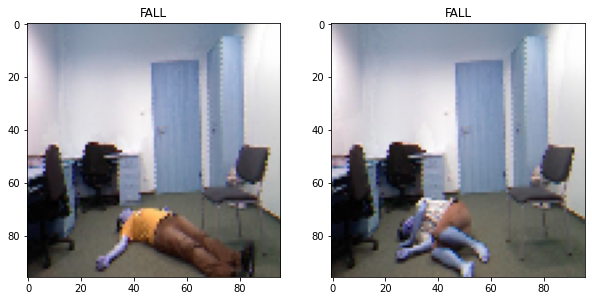

In [ ]:
#cam0
plot_samples(train_images,train_labels)

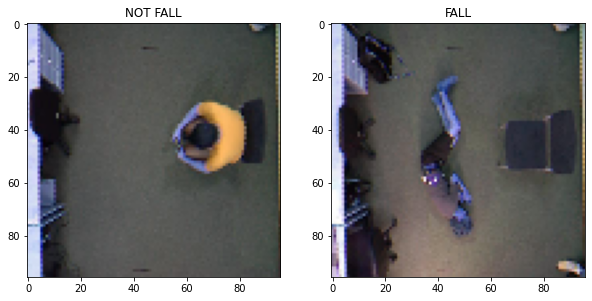

In [ ]:
#cam1
plot_samples(train_images2,train_labels2)

## Splitto i dati in train e validation set, costruisco e alleno il modello

In [ ]:
from sklearn.model_selection import train_test_split

#cam0
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2)

#cam1
X_train2, X_val2, y_train2, y_val2 = train_test_split(train_images2, train_labels2, stratify=train_labels2, test_size=0.2)

In [ ]:
print(len(X_train),len(X_val),len(y_train),len(y_val))
print(len(X_train2),len(X_val2),len(y_train2),len(y_val2))

2260 566 2260 566
2261 566 2261 566


In [ ]:
def conv2d(filters: int, name):
    return Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name=name)

Per info su architettura fallnet: https://ejmcm.com/article_5270_c142136d00a954b48008a9226edd5a07.pdf (pag 742)

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, ReLU
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.regularizers import l2

# fallnet architecture
def fallnet(X_train):
  model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), name='inputs')

  conv1 = conv2d(16, name='convoluton_1')(model_input)
  act1 = ReLU(name='activation_1')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2), name='pooling_1')(act1)

  conv2 = conv2d(16, name='convolution_2')(pool1)
  act2 = ReLU(name='activation_2')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2), name='pooling_2')(act2)

  conv3 = conv2d(32, name='convolution_3')(pool2)
  act3 = ReLU(name='activation_3')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2), name='pooling_3')(act3)

  conv4 = conv2d(32, name='convolution_4')(pool3)
  act4 = ReLU(name='activation_4')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2), name='pooling_4')(act4)

  conv5 = conv2d(64, name='convolition_5')(pool4)
  act5 = ReLU(name='activation_5')(conv5)
  pool5 = MaxPooling2D(pool_size=(2, 2), name='pooling_5')(act5)

  conv6 = conv2d(64, name='convolution_6')(pool5)
  act6 = ReLU(name='activation_6')(conv6)
  pool6 = MaxPooling2D(pool_size=(2, 2), name='pooling_6')(act6)

  flat = Flatten(name='flatten')(pool6)
  dense1 = Dense(32, name='dense1')(flat)
  output = Dense(1, activation='sigmoid', name='output')(dense1)

  model = Model(inputs=[model_input], outputs=[output])
  return model

In [ ]:
#cam0
model = fallnet(X_train)

#cam1
model2 = fallnet(X_train2)

#model2.summary()

### Addestramento del modello

In [ ]:
def train(model,X_train,y_train,X_val,y_val,epoche):
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(X_train,y_train, epochs = epoche, validation_data = (X_val, y_val))
  return history

In [ ]:
#cam0
history = train(model,X_train,y_train,X_val,y_val,15)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
71/71 [==============================] - 10s 15ms/step - loss: 1.3038 - accuracy: 0.7973 - val_loss: 0.1690 - val_accuracy: 0.9488
Epoch 2/15
71/71 [==============================] - 1s 8ms/step - loss: 0.1203 - accuracy: 0.9544 - val_loss: 0.1034 - val_accuracy: 0.9647
Epoch 3/15
71/71 [==============================] - 1s 8ms/step - loss: 0.1008 - accuracy: 0.9646 - val_loss: 0.0701 - val_accuracy: 0.9717
Epoch 4/15
71/71 [==============================] - 1s 8ms/step - loss: 0.0720 - accuracy: 0.9752 - val_loss: 0.1274 - val_accuracy: 0.9647
Epoch 5/15
71/71 [==============================] - 1s 8ms/step - loss: 0.0639 - accuracy: 0.9761 - val_loss: 0.0761 - val_accuracy: 0.9735
Epoch 6/15
71/71 [==============================] - 1s 8ms/step - loss: 0.0581 - accuracy: 0.9792 - val_loss: 0.0773 - val_accuracy: 0.9788
Epoch 7/15
71/71 [==============================] - 1s 8ms/step - loss: 0.0882 - accuracy: 0.9686 - val_loss: 0.0493 - val_accuracy: 0.9770
Epoch 8/15
71/71 [

In [ ]:
#cam1
history2 = train(model2,X_train2,y_train2,X_val2,y_val2,15)

Epoch 1/15
71/71 [==============================] - 2s 15ms/step - loss: 0.9167 - accuracy: 0.7147 - val_loss: 0.1564 - val_accuracy: 0.9329
Epoch 2/15
71/71 [==============================] - 1s 8ms/step - loss: 0.1802 - accuracy: 0.9323 - val_loss: 0.2147 - val_accuracy: 0.9152
Epoch 3/15
71/71 [==============================] - 1s 8ms/step - loss: 0.1407 - accuracy: 0.9509 - val_loss: 0.1335 - val_accuracy: 0.9523
Epoch 4/15
71/71 [==============================] - 1s 8ms/step - loss: 0.1007 - accuracy: 0.9615 - val_loss: 0.1160 - val_accuracy: 0.9594
Epoch 5/15
71/71 [==============================] - 1s 8ms/step - loss: 0.0736 - accuracy: 0.9713 - val_loss: 0.0962 - val_accuracy: 0.9647
Epoch 6/15
71/71 [==============================] - 1s 8ms/step - loss: 0.0632 - accuracy: 0.9770 - val_loss: 0.0911 - val_accuracy: 0.9682
Epoch 7/15
71/71 [==============================] - 1s 8ms/step - loss: 0.0704 - accuracy: 0.9699 - val_loss: 0.0399 - val_accuracy: 0.9859
Epoch 8/15
71/71 [=

## Accuracy/Loss vs Epochs

In [ ]:
def plot_history(history):
  # Sommario history della accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Sommario history della loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

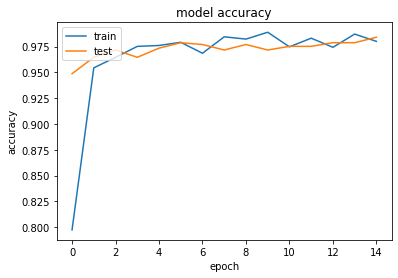

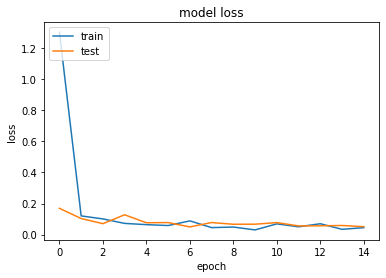

In [ ]:
#cam0
plot_history(history)

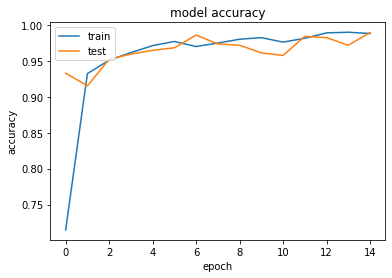

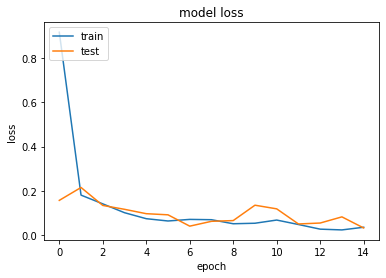

In [ ]:
#cam1
plot_history(history2)

Salvataggio dei modelli in formato h5

In [ ]:
#model.save('drive/MyDrive/model.h5')
#model2.save('drive/MyDrive/model2.h5')
#print('Weights saved.')

## Testing del modello

In [ ]:
print(type(test_images))
print(test_images.shape)

<class 'numpy.ndarray'>
(169, 96, 96, 3)


In [ ]:
print(type(test_images2))
print(test_images2.shape)

<class 'numpy.ndarray'>
(169, 96, 96, 3)


In [ ]:
predicted_labels = (model.predict(test_images) >= 0.5).astype('int64').flatten()

6/6 [==============================] - 0s 28ms/step


In [ ]:
predicted_labels2 = (model2.predict(test_images2) >= 0.5).astype('int64').flatten()

6/6 [==============================] - 0s 3ms/step


Visualizzazione risultati

In [ ]:
def plot_results(test_images,predicted_labels,test_labels):
  row = 3
  col = 5
  fig, axes = plt.subplots(row, col, figsize=(16, 14))
  c = 0
  good_predicted = 0
  total_tested = 0
  for i in range(row):
      for j in range(col):
          axes[i][j].imshow(test_images[c])
          axes[i][j].set_title(f'Predicted: {get_label(predicted_labels[c])}', fontsize=8)
          axes[i][j].set_xlabel(f'Actual: {get_label(test_labels[c])}', fontsize=8)
          if get_label(predicted_labels[c]) == get_label(test_labels[c]):
            good_predicted += 1
          total_tested += 1
          c += 1

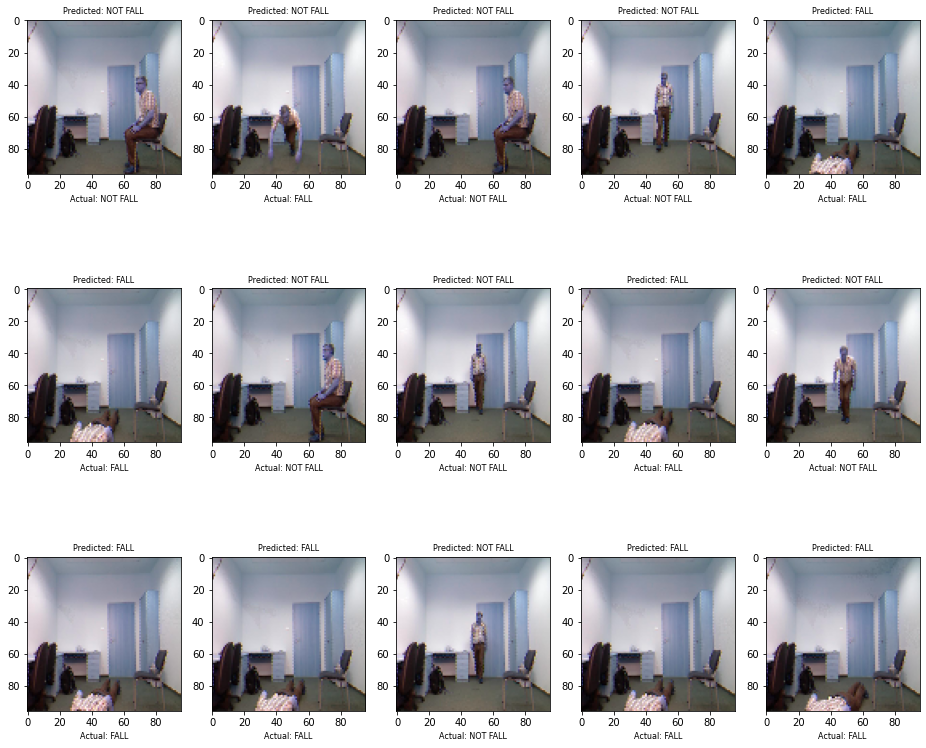

In [ ]:
plot_results(test_images,predicted_labels,test_labels)

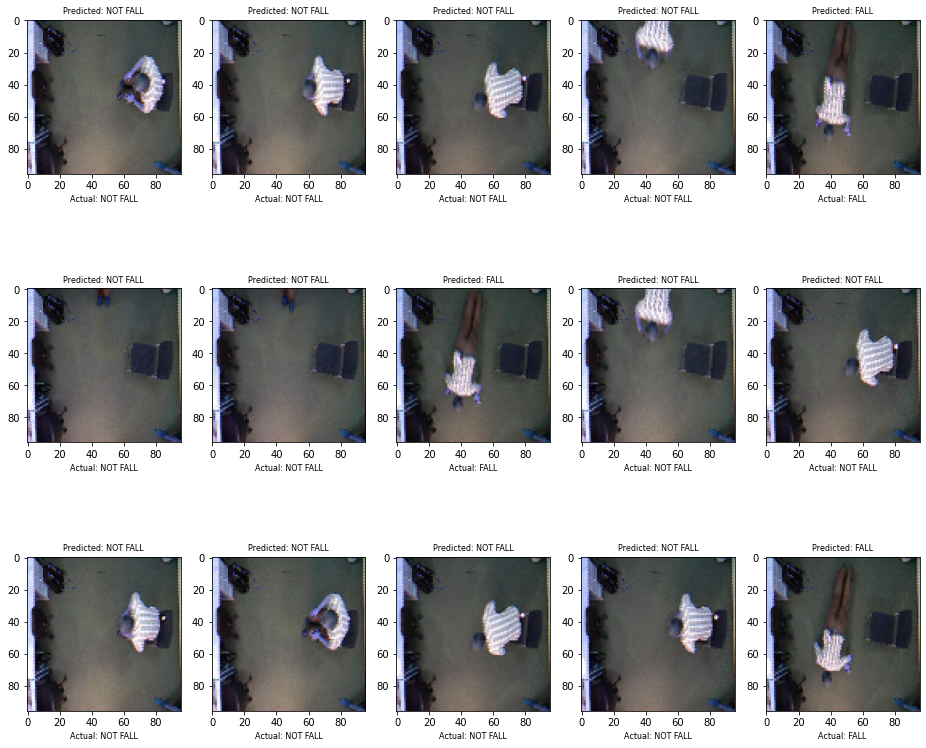

In [ ]:
plot_results(test_images2,predicted_labels2,test_labels2)

Calcolo accuracy su tutti i sample di test

In [ ]:
len(test_labels)
len(test_labels2)

169

In [ ]:
def get_accuracy(predicted_labels,test_labels):
  good_predicted = 0
  total_tested = 0
  for i in range (0,len(test_labels)):
    if get_label(predicted_labels[i]) == get_label(test_labels[i]):
      good_predicted += 1
    total_tested += 1
  print("Accuracy: "+str(good_predicted)+"/"+str(total_tested) + " ("+str(good_predicted*100/total_tested)+"%)")

In [ ]:
get_accuracy(predicted_labels,test_labels) #cam0
get_accuracy(predicted_labels2,test_labels2) #cam1

Accuracy: 164/169 (97.0414201183432%)
Accuracy: 163/169 (96.44970414201184%)


### Salvataggio dei modelli

In [ ]:
type(model)

keras.engine.functional.Functional

In [ ]:
#model.save('drive/MyDrive/UR-Fall-Dataset-cam0-rgb-adl/models/fallnet_15epochs')

In [ ]:
#model2.save('drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl/models/fallnet_15epochs')

### Load dei modelli

In [ ]:
model = keras.models.load_model('drive/MyDrive/UR-Fall-Dataset-cam0-rgb-adl/models/fallnet_15epochs')

In [ ]:
model2 = keras.models.load_model('drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl/models/fallnet_15epochs')

### Inferenza su video

In [ ]:
import imageio

def video_to_frames(video_path,fx=96,fy=96,cut_half=True):
  vidcap = cv2.VideoCapture(video_path)
  success,image = vidcap.read()
  count = 0
  frames = []
  while success:
      cv2.imwrite("frame"+str(count)+".jpg", image)     # save frame as JPEG file      
      success,image = vidcap.read()

      
      img = cv2.imread("frame"+str(count)+".jpg")

      if cut_half == True:
        #Prendo solo la metà destra del video
        height, width, channels = img.shape
        width_cutoff = width // 2
        img = img[:, width_cutoff:]
      
      img = cv2.resize(img, (fx,fy))
      frames.append(img)

      #print('Read a new frame: ', success)
      count += 1

  frames = np.array(frames,ndmin=4)
  return frames

In [ ]:
frames = video_to_frames('drive/MyDrive/UR-Fall-Dataset-cam0-rgb-adl/fall-29-cam0.mp4')
frames2 = video_to_frames('drive/MyDrive/UR-Fall-Dataset-cam1-rgb-adl/fall-30-cam1.mp4')

In [ ]:
print(type(frames))
print(frames.shape)

print(type(frames2))
print(frames2.shape)

<class 'numpy.ndarray'>
(99, 96, 96, 3)
<class 'numpy.ndarray'>
(70, 96, 96, 3)


In [ ]:
predicted_frame_labels = (model.predict(frames) >= 0.5).astype('int64').flatten()
predicted_frame_labels2 = (model2.predict(frames2) >= 0.5).astype('int64').flatten()

3/3 [==============================] - 0s 52ms/step


In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from time import sleep

def display_frames_results(frames,predicted_frame_labels):
  count = 0
  for img in frames:
    #clear_output()
    print(get_label(predicted_frame_labels[count]))
    cv2_imshow(img)
    count += 1
    sleep(0.1)
  

In [ ]:
display_frames_results(frames,predicted_frame_labels)

NOT FALL


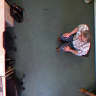

NOT FALL


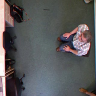

NOT FALL


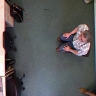

NOT FALL


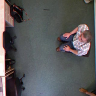

NOT FALL


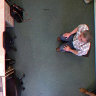

NOT FALL


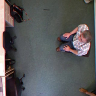

NOT FALL


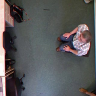

NOT FALL


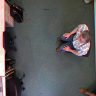

NOT FALL


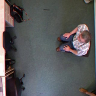

NOT FALL


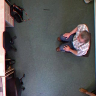

NOT FALL


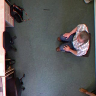

NOT FALL


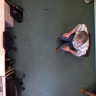

NOT FALL


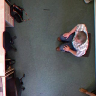

NOT FALL


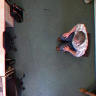

NOT FALL


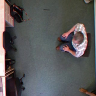

NOT FALL


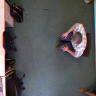

NOT FALL


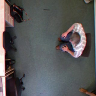

NOT FALL


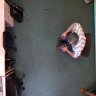

NOT FALL


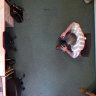

NOT FALL


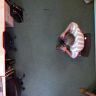

NOT FALL


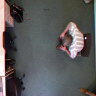

NOT FALL


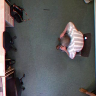

NOT FALL


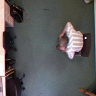

NOT FALL


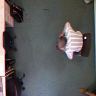

NOT FALL


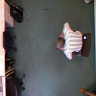

NOT FALL


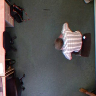

NOT FALL


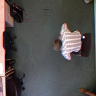

NOT FALL


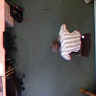

NOT FALL


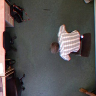

NOT FALL


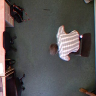

NOT FALL


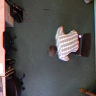

NOT FALL


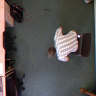

NOT FALL


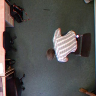

NOT FALL


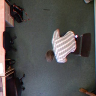

NOT FALL


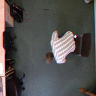

NOT FALL


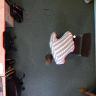

NOT FALL


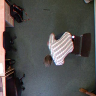

NOT FALL


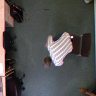

NOT FALL


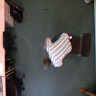

NOT FALL


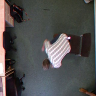

NOT FALL


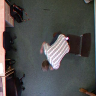

NOT FALL


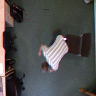

NOT FALL


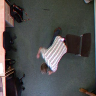

NOT FALL


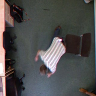

NOT FALL


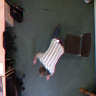

FALL


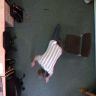

FALL


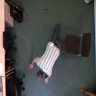

FALL


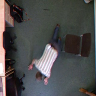

FALL


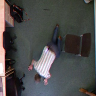

FALL


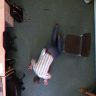

FALL


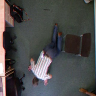

FALL


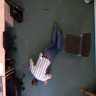

FALL


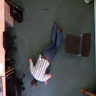

FALL


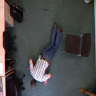

FALL


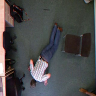

FALL


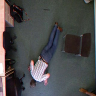

FALL


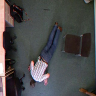

FALL


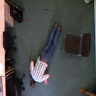

FALL


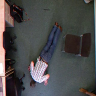

FALL


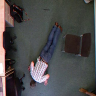

FALL


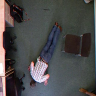

FALL


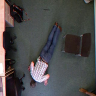

FALL


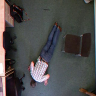

FALL


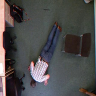

FALL


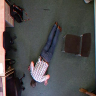

FALL


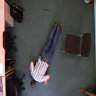

FALL


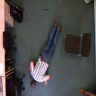

FALL


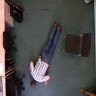

FALL


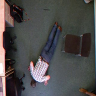

FALL


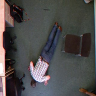

In [ ]:
display_frames_results(frames2,predicted_frame_labels2)

# Inferenza su video personale (esterno al dataset utilizzato)

In [ ]:
frames3 = video_to_frames('drive/MyDrive/UR-Fall-Dataset-cam0-rgb-adl/stefan_caduta2.mp4', 65,65,False)
predicted_frame_labels3 = (model.predict(frames3) >= 0.5).astype('int64').flatten()
display_frames_results(frames3,predicted_frame_labels3)

# CLASSIFICATORE LSTM

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(units=1)
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 flatten_6 (Flatten)         (None, 25600)            

Compila e addestra

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

print(np.isnan(train_images).any())
print(np.isnan(train_labels).any())
print(np.isnan(test_images).any())
print(np.isnan(test_labels).any())

(2826, 96, 96, 3)
(2826,)
(169, 96, 96, 3)
(169,)
False
False
False
False


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
89/89 [==============================] - 2s 13ms/step - loss: nan - accuracy: 0.5962 - val_loss: nan - val_accuracy: 0.6746
Epoch 2/10
89/89 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.5962 - val_loss: nan - val_accuracy: 0.6746
Epoch 3/10
89/89 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.5962 - val_loss: nan - val_accuracy: 0.6746
Epoch 4/10
89/89 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.5962 - val_loss: nan - val_accuracy: 0.6746
Epoch 5/10
89/89 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.5962 - val_loss: nan - val_accuracy: 0.6746
Epoch 6/10
89/89 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.5962 - val_loss: nan - val_accuracy: 0.6746
Epoch 7/10
89/89 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.5962 - val_loss: nan - val_accuracy: 0.6746
Epoch 8/10
89/89 [==============================] - 1s 

Valutazione

6/6 - 0s - loss: nan - accuracy: 0.6746 - 41ms/epoch - 7ms/step
0.6745561957359314


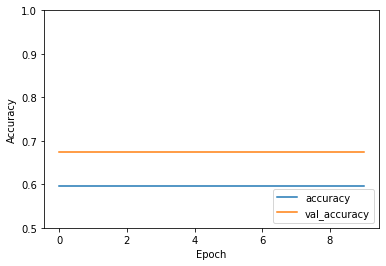

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=3)
print(test_acc)

0.6745561957359314


Inferenza

In [ ]:
predicted_labels = (model.predict(test_images) >= 0.5).astype('int64').flatten()

6/6 [==============================] - 0s 5ms/step


In [ ]:
get_accuracy(predicted_labels,test_labels)

Accuracy: 114/169 (67.45562130177515%)


Salvataggio modello

In [ ]:
model.save("drive/MyDrive/UR-Fall-Dataset-cam0-rgb-adl/models/lstm_10epoche")

In [ ]:
model.save('drive/MyDrive/UR-Fall-Dataset-cam0-rgb-adl/models/lstm_10epoche.h5')